In [1]:
#TODO: link to paper (arXiv)
# print xxx -> print(xxx)
# change path in samples_dataframe
# add readme (with instructions to download CUB images)

Requirements:  
python 2.7.9  
torch 1.1.0  
sklearn 0.19.2  
numpy 1.14.3  
pandas 0.23.0  
matplotlib 2.2.2  
scipy 1.0.0  
jupyter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd

import sklearn
import sklearn.covariance

import scipy

import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Notations:

N: number of samples (may be different between train and test)  
C: number of classes  
D: dimension of visual space  
K: dimension of semantic space  
H: dimension of learned representation (projected X and S)  

X: usually N x D matrix of visual samples  
S: usually C x K matrix of semantic prototypes

In [4]:
if torch.cuda.is_available():
    torch.cuda.set_device(1L)
    DEVICE = "cuda:1"
else:
    DEVICE = "cpu"

# Data imports

## Dataset

In [5]:
def normalization(X):
    """
        X: N x D matrix (numpy array)
        returns a matrix with same dimensions as X whose rows have unit l2-norm
        
    """
    norms = np.linalg.norm(X, axis=1).reshape(-1, 1) + 1e-32
    return X / norms

Loading CUB dataset

In [6]:
PATH = 'data'

In [7]:
# Represents...
classes_dataframe = pd.read_csv(os.path.join(PATH, 'df_classes.csv'))
print(classes_dataframe.shape)
classes_dataframe.head()

(200, 9)


class  original_class                  class_name split_ss1 split_ss2  \
0      0               1  001.Black_footed_Albatross      test      test   
1      1               2        002.Laysan_Albatross       val     train   
2      2               3         003.Sooty_Albatross     train     train   
3      3               4       004.Groove_billed_Ani      test      test   
4      4               5          005.Crested_Auklet     train       val   

  split_ss3 split_ps1 split_ps2 split_ps3  
0      test     train       val     train  
1       val     train       val     train  
2     train     train     train     train  
3      test      test      test      test  
4     train       val     train       val

split_ss1, split_ss2 and split_ss3: indicates...

In [8]:
# Represents...
samples_dataframe = pd.read_csv(os.path.join(PATH, 'df.csv'))
print(samples_dataframe.shape)
samples_dataframe.head()

(11788, 11)


image_id                                               path  class  \
0         1  /scratch_global/yannick/CUB_200_2011/images/00...      0   
1         2  /scratch_global/yannick/CUB_200_2011/images/00...      0   
2         3  /scratch_global/yannick/CUB_200_2011/images/00...      0   
3         4  /scratch_global/yannick/CUB_200_2011/images/00...      0   
4         5  /scratch_global/yannick/CUB_200_2011/images/00...      0   

   original_class                  class_name split_ss1 split_ss2 split_ss3  \
0               1  001.Black_footed_Albatross      test      test      test   
1               1  001.Black_footed_Albatross      test      test      test   
2               1  001.Black_footed_Albatross      test      test      test   
3               1  001.Black_footed_Albatross      test      test      test   
4               1  001.Black_footed_Albatross      test      test      test   

         split_ps1      split_ps2        split_ps3  
0            train            val            train  
1            train  seen_test_val  seen_test_train  
2  seen_test_train            val  seen_test_train  
3            train            val            train  
4            train  seen_test_val         seen_val

split_ss1, split_ss2 indicate...

In [9]:
# Represents...
attributes = np.load(os.path.join(PATH, 'attributes.npy'))
attributes = normalization(attributes) # we use attributes with unit l2-norm
print(attributes.shape)

(200, 312)


We have a total of C = 200 classes, with semantic prototypes of dimension K = 312

In [10]:
# Represents...
visual_features = np.load(os.path.join(PATH, 'features_resnet101_10crop.npy'))
visual_features = normalization(visual_features) # we use visual features with unit l2-norm
print(visual_features.shape)

(11788, 2048)


We have a total of N = 11788 visual samples in the dataset, with dimension D = 2048

In [11]:
class ZslDataset:
    
    """
    Represents a ZSL dataset
    """
    
    def __init__(self, df_classes, df, attributes, features):
        """
        Parameters:
            df_classes: C-row pandas dataframe representing classes
                should contain columns 'class', 'class_name', and splits
            df: N-row pandas dataframe representing samples
                should contain columns 'class' and splits
            attributes: C x K numpy array containing semantic representation of class prototypes
            features: N x D numpy array containing visual features representation of samples
        """
        self.df_classes = df_classes
        self.df = df
        self.attributes = attributes
        self.features = features

In [12]:
dataset = ZslDataset(classes_dataframe, samples_dataframe, attributes, visual_features)

## Train / val / test split

In [13]:
def get_indexes(dataframe, column_name, values):
    return np.array(dataframe[dataframe[column_name].apply(lambda i: i in values)].index)

In [14]:
class DatasetSplit:
    """
    Used to quickly access training / testing classes, samples etc from a dataset.
    
    Attributes:
        classes: list of all classes (seen_classes + unseen_classes)
        seen_classes: list of classes used in training (#seen_classes: number of seen_classes)
        unseen_classes: list of classes not seen during training (#unseen_classes: same as above)
        ----
        S: C x K matric, semantic representations of class prototypes (i.e. attributes) 
        S_tr: #seen_classes x K matrix, S restricted to training classes
        S_te: #unseen_classes x K matrix, S restricted to unseen classes
        ----
        X_tr: N x D matrix, visual features of training examples
        Y_tr: classes of training examples among all classes, in [0, C-1]
        Y_tr_: labels of training examples among seen_classes, in [0, #seen_classes-1]
        Y_classes2labels: dict, used to convert a class to a label
        ----
        X_te_U
        Y_te_U
        X_te_S
        Y_te_S
        ----
        
    Method info displays additional documentation.
    """
    
    def __init__(self, dataset,
                 split_name="gzsl_split",
                 train_split=["train", "val", "seen_val"],
                 unseen_test_split=["test"], seen_test_split=["seen_test_train", "seen_test_val"]):
        """
        By default, standard GZSL train / test split
        
        Parameters:
            dataset: ZslDataset instance
            sample_split_name
            class_split_name
            train_split
            unseen_test_split
            seen_test_split
        """
        sample_split_name = class_split_name = split_name
        
        self.dataset = dataset
        self.seen_classes = get_indexes(dataset.df_classes, class_split_name, train_split)
        self.unseen_classes = get_indexes(dataset.df_classes, class_split_name, unseen_test_split)
        self.classes = np.array(sorted(list(self.seen_classes) + list(self.unseen_classes)))
        self.S = dataset.attributes
        self.S_tr = self.S[self.seen_classes]
        self.S_te = self.S[self.unseen_classes]
        
        training_examples_indexes = get_indexes(dataset.df, sample_split_name, train_split)
        self.X_tr = dataset.features[training_examples_indexes]
        self.Y_tr = np.array(dataset.df.iloc[training_examples_indexes]["class"])
        self.Y_classes2labels = dict(zip(self.seen_classes, range(self.seen_classes.shape[0])))
        self.Y_tr_ = np.array([self.Y_classes2labels[c] for c in self.Y_tr])
        
        unseen_testing_examples_indexes = get_indexes(dataset.df, sample_split_name, unseen_test_split)
        self.X_te_U = dataset.features[unseen_testing_examples_indexes]
        self.Y_te_U = np.array(dataset.df.iloc[unseen_testing_examples_indexes]["class"])
        
        seen_testing_examples_indexes = get_indexes(dataset.df, sample_split_name, seen_test_split)
        self.X_te_S = dataset.features[seen_testing_examples_indexes]
        self.Y_te_S = np.array(dataset.df.iloc[seen_testing_examples_indexes]["class"])
        
    def info(self):
        dataset_size, number_of_classes = self.dataset.df.shape[0], self.dataset.df_classes.shape[0]
        print "Initial dataset size: %i samples belonging to %i classes" % \
            (dataset_size, number_of_classes)
        print "Seen / unseen classes: %i (%.1f%%) / %i (%.1f%%)" % \
            (self.seen_classes.shape[0], 100. * self.seen_classes.shape[0] / number_of_classes,
             self.unseen_classes.shape[0], 100. * self.unseen_classes.shape[0] / number_of_classes)
        print "Training samples: %i (%.1f%%)" % \
            (self.X_tr.shape[0], 100. * self.X_tr.shape[0] / dataset_size)
        print "Testing samples belonging to unseen classes: %i (%.1f%%)" % \
            (self.X_te_U.shape[0], 100. * self.X_te_U.shape[0] / dataset_size)
        print "Testing samples belonging to seen classes: %i (%.1f%%)" % \
            (self.X_te_S.shape[0], 100. * self.X_te_S.shape[0] / dataset_size)

In [15]:
def get_zsl_train_split(dataset, split_name):
    return DatasetSplit(
        dataset, split_name=split_name,
        train_split = ["train", "seen_val", "seen_test_train"],
        unseen_test_split = ["val", "seen_test_val"], seen_test_split = ["seen_val"] # irrelevant
    )

def get_zsl_test_split(dataset, split_name):
    return DatasetSplit(
        dataset, split_name=split_name,
        train_split = ["train", "val", "seen_val", "seen_test_train", "seen_test_val"],
        unseen_test_split = ["test"], seen_test_split = ["seen_val"] # irrelevant
    )

def get_gzsl_train_split(dataset, split_name):
    return DatasetSplit(
        dataset, split_name=split_name,
        train_split = ["train"],
        unseen_test_split = ["val"], seen_test_split = ["seen_val"]
    )

def get_gzsl_test_split(dataset, split_name):
    return DatasetSplit(
        dataset, split_name=split_name,
        train_split = ["train", "val", "seen_val"],
        unseen_test_split = ["test"], seen_test_split = ["seen_test_train", "seen_test_val"]
    )

In [16]:
test_split_zsl = get_zsl_test_split(dataset, "split_ps1")

In [17]:
test_split_zsl.info()

Initial dataset size: 11788 samples belonging to 200 classes
Seen / unseen classes: 150 (75.0%) / 50 (25.0%)
Training samples: 8821 (74.8%)
Testing samples belonging to unseen classes: 2967 (25.2%)
Testing samples belonging to seen classes: 940 (8.0%)


In [18]:
validation_split_zsl_1 = get_zsl_train_split(dataset, "split_ps1")
validation_split_zsl_2 = get_zsl_train_split(dataset, "split_ps2")
validation_split_zsl_3 = get_zsl_train_split(dataset, "split_ps3")

In [19]:
validation_split_zsl_1.info()

Initial dataset size: 11788 samples belonging to 200 classes
Seen / unseen classes: 100 (50.0%) / 50 (25.0%)
Training samples: 5875 (49.8%)
Testing samples belonging to unseen classes: 2946 (25.0%)
Testing samples belonging to seen classes: 940 (8.0%)


In [20]:
validation_splits_zsl = [validation_split_zsl_1, validation_split_zsl_2, validation_split_zsl_3]

# Flexible semantic margin

cf. Section 3.2

In [21]:
def pairwise_mahalanobis(S1, S2, Cov_1=None):
    """
        S1: C1 x K matrix (torch.FloatTensor)
          -> C1 K-dimensional semantic prototypes
        S2: C2 x K matrix (torch.FloatTensor)
          -> C2 K-dimensional semantic prototypes
        Sigma_1: K x K matrix (torch.FloatTensor)
          -> inverse of the covariance matrix Sigma; used to compute Mahalanobis distances
          by default Sigma is the identity matrix (and so distances are euclidean distances)
        
        returns an C1 x C2 matrix corresponding to the Mahalanobis distance between each element of S1 and S2
        (Equation 5)
    """
    if S1.dim() != 2 or S2.dim() != 2 or S1.shape[1] != S2.shape[1]:
        raise RuntimeError("Bad input dimension")
    C1, K = S1.shape
    C2, K = S2.shape
    if Cov_1 is None:
        Cov_1 = torch.eye(K)
    if Cov_1.shape != (K, K):
        raise RuntimeError("Bad input dimension")
    
    S1S2t = S1.matmul(Cov_1).matmul(S2.t())
    S1S1 = S1.matmul(Cov_1).mul(S1).sum(dim=1, keepdim=True).expand(-1, C2)
    S2S2 = S2.matmul(Cov_1).mul(S2).sum(dim=1, keepdim=True).t().expand(C1, -1)
    return torch.sqrt(torch.abs(S1S1 + S2S2 - 2. * S1S2t) + 1e-32)  # to avoid numerical instabilities

In [22]:
def distance_matrix(S, mahalanobis=True, mean=1., std=0.5):
    """
        S: C x K matrix (numpy array)
          -> K-dimensional prototypes of C classes
        mahalanobis: indicates whether to use Mahalanobis distance (uses euclidean distance if False)
        mean & std: target mean and standard deviation
        
        returns a C x C matrix corresponding to the Mahalanobis distance between each pair of elements of S
        rescaled to have approximately target mean and standard deviation while keeping values positive
        (Equation 6)
    """
    Cov_1 = None
    if mahalanobis:
        #Cov = np.cov(S.T)
        #Cov, _ = sklearn.covariance.ledoit_wolf(S) # robust estimation of covariance matrix
        lw = sklearn.covariance.LedoitWolf(assume_centered=False).fit(S)
        #Cov_1 = torch.FloatTensor(np.linalg.inv(Cov))
        Cov_1 = torch.FloatTensor(lw.precision_)
    S = torch.FloatTensor(S)
    
    distances = pairwise_mahalanobis(S, S, Cov_1)
    
    # Rescaling to have approximately target mean and standard deviation while keeping values positive
    max_zero_distance = distances.diag().max()
    positive_distances = np.array([x for x in distances.view(-1) if x > max_zero_distance])
    emp_std = float(positive_distances.std())
    emp_mean = float(positive_distances.mean())
    distances = F.relu(std * (distances - emp_mean) / emp_std + mean)
    max_zero_distance = distances.diag().max()
    positive_distances = np.array([x for x in distances.view(-1) if x > max_zero_distance])
    emp_std = float(positive_distances.std())
    emp_mean = float(positive_distances.mean())
    distances = F.relu(std * (distances - emp_mean) / emp_std + mean)
    return distances

In [23]:
def test_distance(S):
    C = S.shape[0]
    cov = sklearn.covariance.LedoitWolf(assume_centered=True)
    #cov = sklearn.covariance.OAS(assume_centered=False)
    cov.fit(S)
    res = np.zeros((C, C))
    for i in range(C):
        for j in range(C):
            res[i,j] = np.sqrt((S[i] - S[j]).T.dot(cov.precision_).dot(S[i] - S[j]))
    return res

## Examples

For visualization, we consider semantic distances for all classes.

Note that for training the model, only seen classes are used.

In [24]:
semantic_distances = distance_matrix(attributes, mahalanobis=True, mean=1, std=0.2)

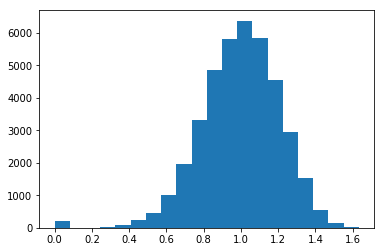

In [25]:
plt.hist(semantic_distances.reshape(-1), bins=20)
plt.show()

In [26]:
# For each class, we find the top k semantically closest classes
_, closest_classes = semantic_distances.topk(k=5, dim=1, largest=False)
closest_classes = closest_classes[:,1:] # closest element for each class is itself

# For each class, we find the top k semantically farthest classes
_, farthest_classes = semantic_distances.topk(k=5, dim=1, largest=True)
farthest_classes = farthest_classes[:,1:] # closest element for each class is itself

In [27]:
for i, c in enumerate(closest_classes[:4]):
    print "Closest classes to %s:" % classes_dataframe.iloc[i]["class_name"]
    for k in c:
        print "  %s" % classes_dataframe.iloc[k.item()]["class_name"]

Closest classes to 001.Black_footed_Albatross:
  030.Fish_Crow
  027.Shiny_Cowbird
  039.Least_Flycatcher
  029.American_Crow
Closest classes to 002.Laysan_Albatross:
  059.California_Gull
  030.Fish_Crow
  062.Herring_Gull
  029.American_Crow
Closest classes to 003.Sooty_Albatross:
  029.American_Crow
  062.Herring_Gull
  030.Fish_Crow
  039.Least_Flycatcher
Closest classes to 004.Groove_billed_Ani:
  027.Shiny_Cowbird
  107.Common_Raven
  030.Fish_Crow
  029.American_Crow


In [28]:
for i, c in enumerate(farthest_classes[:4]):
    print "Farthest classes to %s:" % classes_dataframe.iloc[i]["class_name"]
    for k in c:
        print "  %s" % classes_dataframe.iloc[k.item()]["class_name"]

Farthest classes to 001.Black_footed_Albatross:
  018.Spotted_Catbird
  083.White_breasted_Kingfisher
  048.European_Goldfinch
  087.Mallard
Farthest classes to 002.Laysan_Albatross:
  083.White_breasted_Kingfisher
  018.Spotted_Catbird
  016.Painted_Bunting
  075.Green_Jay
Farthest classes to 003.Sooty_Albatross:
  087.Mallard
  070.Green_Violetear
  106.Horned_Puffin
  083.White_breasted_Kingfisher
Farthest classes to 004.Groove_billed_Ani:
  083.White_breasted_Kingfisher
  087.Mallard
  048.European_Goldfinch
  016.Painted_Bunting


In [29]:
def get_path_for_class(c):
    return samples_dataframe[samples_dataframe["class"] == c].iloc[0]["path"]

In [30]:
def plot_closest_and_farthest_classes(c):
    class_name = classes_dataframe.iloc[c]["class_name"]
    closest_classes_to_c = closest_classes[c]
    farthest_classes_to_c = farthest_classes[c]
    fig=plt.figure(figsize=(16, 9), constrained_layout=True)
    
    img = matplotlib.image.imread(get_path_for_class(c))
    ax = plt.subplot2grid((3, 4), (0, 0), colspan=4)
    plt.axis('off')
    plt.title(class_name)
    plt.imshow(img)
    
    for i, k in enumerate(closest_classes_to_c):
        class_name_k = classes_dataframe.iloc[k.item()]["class_name"]
        img = matplotlib.image.imread(get_path_for_class(k.item()))
        ax = plt.subplot2grid((3, 4), (1, i))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        #plt.axis('off')
        plt.title(class_name_k)
        if i==0:
            plt.ylabel("Least similar classes     Most similar classes            Reference class", rotation=90, fontsize=14, labelpad=20)
        plt.imshow(img)
    
    for i, k in enumerate(farthest_classes_to_c):
        class_name_k = classes_dataframe.iloc[k.item()]["class_name"]
        img = matplotlib.image.imread(get_path_for_class(k.item()))
        ax = plt.subplot2grid((3, 4), (2, i))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(class_name_k)
        plt.imshow(img)

/home/yannick/envs/pytorch/local/lib/python2.7/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


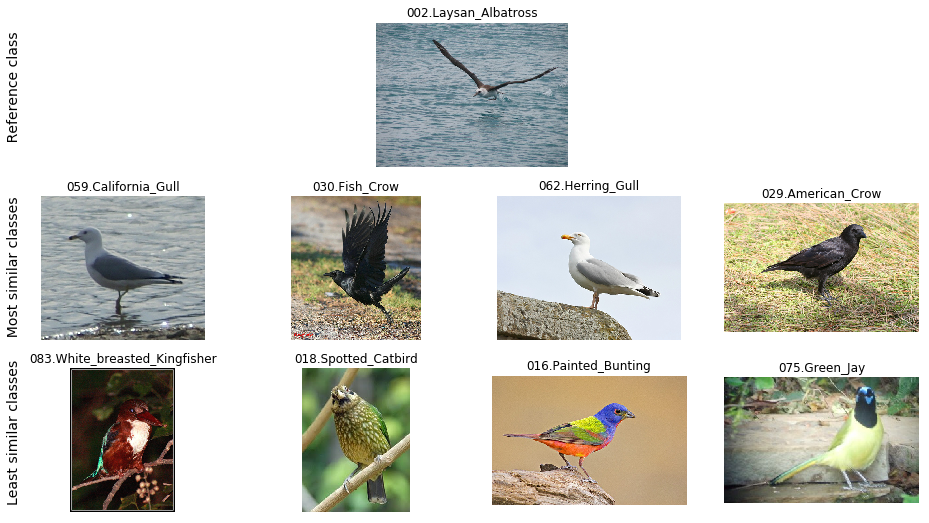

In [31]:
plot_closest_and_farthest_classes(1)

/home/yannick/envs/pytorch/local/lib/python2.7/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


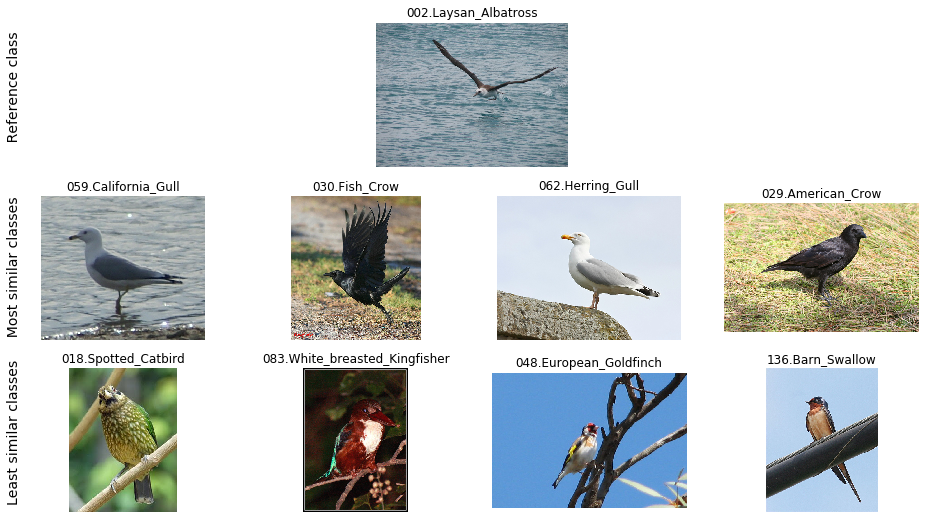

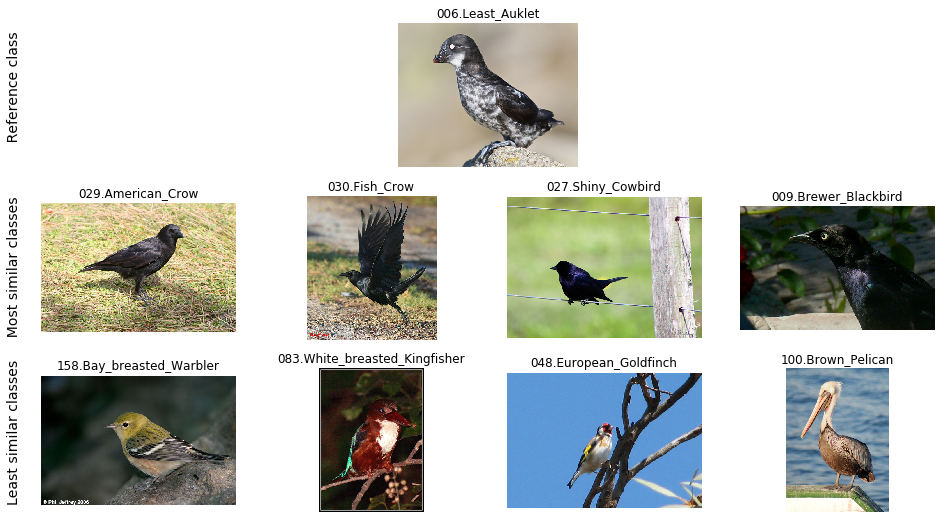

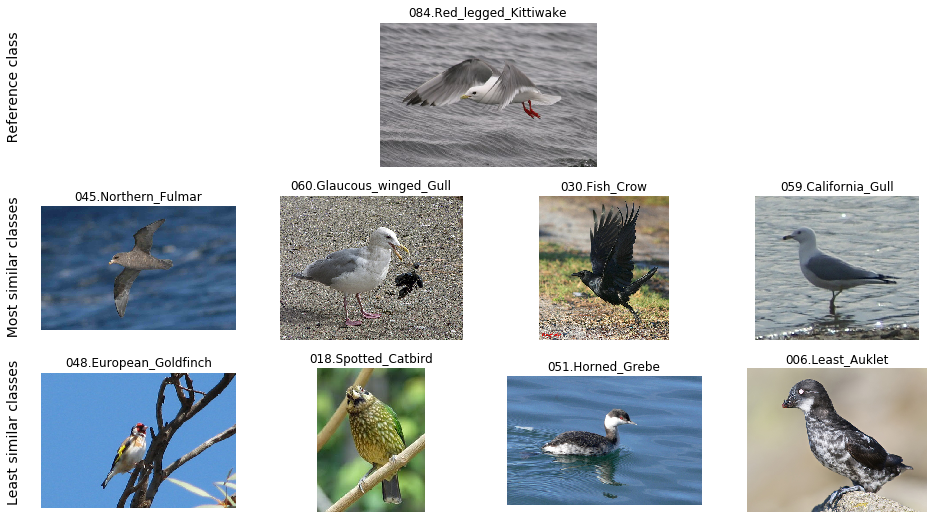

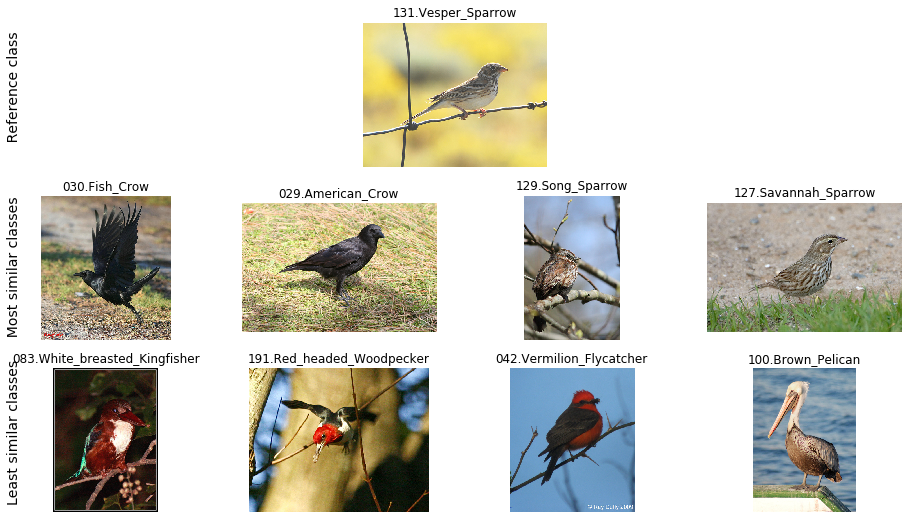

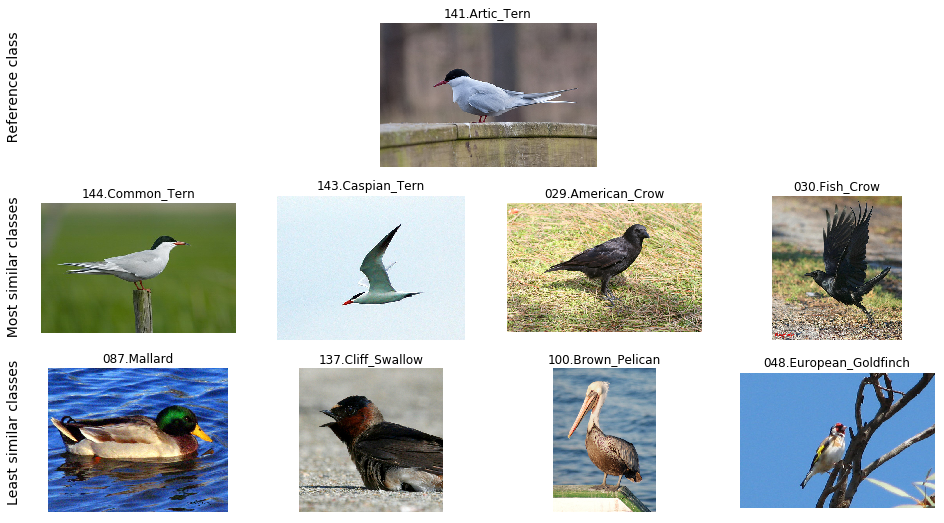

In [291]:
example_classes = [1, 5, 83, 130, 140]
for c in example_classes:
    plot_closest_and_farthest_classes(c)

Surprisingly, ...

# Partial normalization

cf. Section 3.3

In [24]:
def partial_normalization(X, gamma):
    """
        X: N x H matrix (torch.FloatTensor)
          -> projected visual (or semantic) samples
        gamma: scalar between 0 and 1
          -> normalization coefficient
        
        returns N x H matrix corresponding to X matrix where each row has been partially normalize
        (Equation 8)
    """
    partial_norms = 1. / (gamma * (X.norm(p=2, dim=1) - 1) + 1)
    partial_norms = partial_norms.view(-1, 1)
    X = partial_norms * X
    return X

# Relevance weighting

cf. Section 3.4

In [25]:
def class_weights(X_c):
    """
        X_c: N x D matrix (numpy array)
          ->N D-dimensional visual samples, assumed to belong to the same class c
        
        returns the corresponding relevance weights
    """
    mean_vector = X_c.mean(axis=0).reshape(-1, 1)
    distances_to_mean_vector = np.sqrt((X_c.T - mean_vector).T.dot(X_c.T - mean_vector).diagonal())
    distribution = scipy.stats.norm(*scipy.stats.norm.fit(distances_to_mean_vector))
    return 1. - distribution.cdf(distances_to_mean_vector)

In [26]:
def relevance_weigths(X, Y):
    """
        X: N x D matrix (numpy array) of N D-dimensional visual samples
        Y: N dimensional vector (numpy array) of classes
        
        returns an N-dimensional vector corresponding to relevance weights of each visual samples
    """
    weights = np.zeros(Y.shape[0])
    classes = sorted(set(Y))
    for c in classes:
        indexes_c = np.where(Y == c)
        X_c = X[indexes_c]
        weigths_c = class_weights(X_c)
        weights[indexes_c] = weigths_c
    return weights

## Examples

For visualization, we consider relevance weights for all samples.

Note that for training the model, only seen samples from seen classes are used.

In [35]:
weights = relevance_weigths(visual_features, samples_dataframe["class"])

In [36]:
# For each class, we compute the indexes of most and least relevant samples
most_relevant_samples = []
least_relevant_samples = []

for c in classes_dataframe["class"]:
    indexes_samples_in_c = np.array(samples_dataframe["class"] == c)
    
    weights_c = indexes_samples_in_c * weights # we set weights to samples not in class c to 0
    top5_weights_c = np.argsort(weights_c)[::-1][:4]
    most_relevant_samples.append(top5_weights_c)
    
    weights_c = weights_c + (1 - indexes_samples_in_c) # we set weights to samples not in class c to 1
    bottom5_weights_c = np.argsort(weights_c)[:4]
    least_relevant_samples.append(bottom5_weights_c)

most_relevant_samples = np.array(most_relevant_samples)
least_relevant_samples = np.array(least_relevant_samples)

We visualize most and least relevant samples for a few classes.

In [37]:
def plot_most_and_least_relevant_samples(c):
    class_name = classes_dataframe.iloc[c]["class_name"]
    paths_most_relevant = [samples_dataframe.iloc[i]["path"] for i in most_relevant_samples[c]]
    paths_least_relevant = [samples_dataframe.iloc[i]["path"] for i in least_relevant_samples[c]]
    fig=plt.figure(figsize=(16, 6))
    plt.title("Coucou", rotation=90)
    #plt.title('Most (top) and least (bottom) relevant samples for class %s' % class_name)
    #plt.axis('off')
    for i, path in enumerate(paths_most_relevant):
        img = matplotlib.image.imread(path)
        #fig.add_subplot(2, 4, i+1)
        ax = plt.subplot2grid((2, 4), (0, i))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if i==0:
            plt.ylabel("Most relevant samples", rotation=90, fontsize=12, labelpad=15)
        #plt.axis('off')
        plt.imshow(img)
    for i, path in enumerate(paths_least_relevant):
        img = matplotlib.image.imread(path)
        #fig.add_subplot(2, 4, i+5)
        ax = plt.subplot2grid((2, 4), (1, i))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if i==0:
            plt.ylabel("Most relevant samples", rotation=90, fontsize=12, labelpad=15)
        #plt.axis('off')
        plt.imshow(img)
    plt.show()

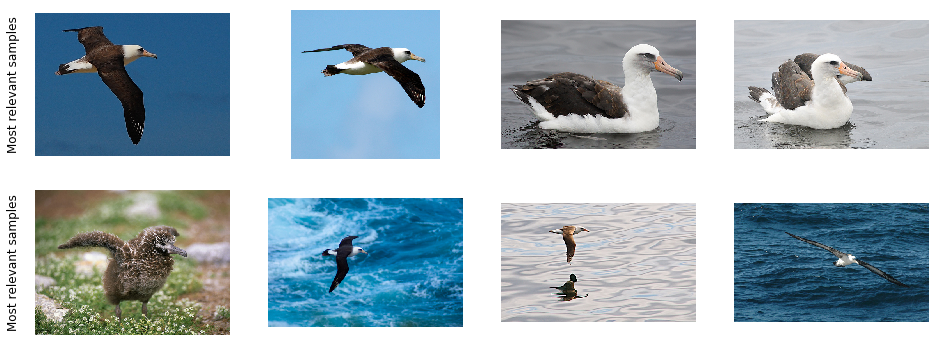

In [38]:
plot_most_and_least_relevant_samples(1)

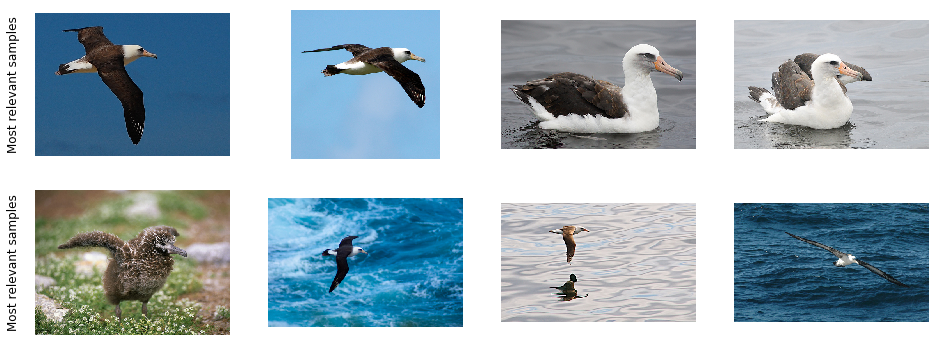

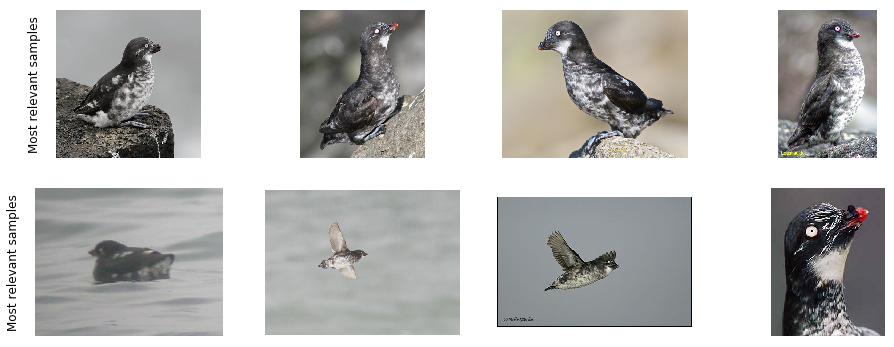

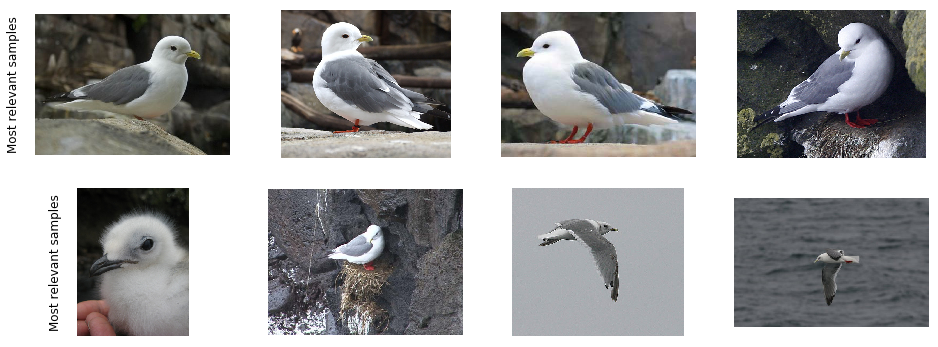

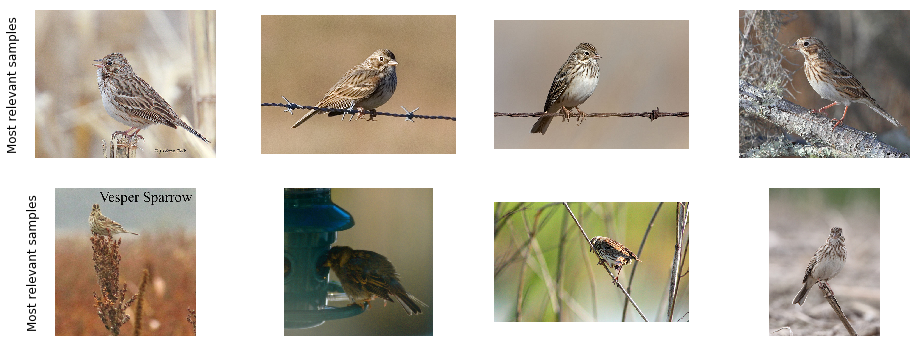

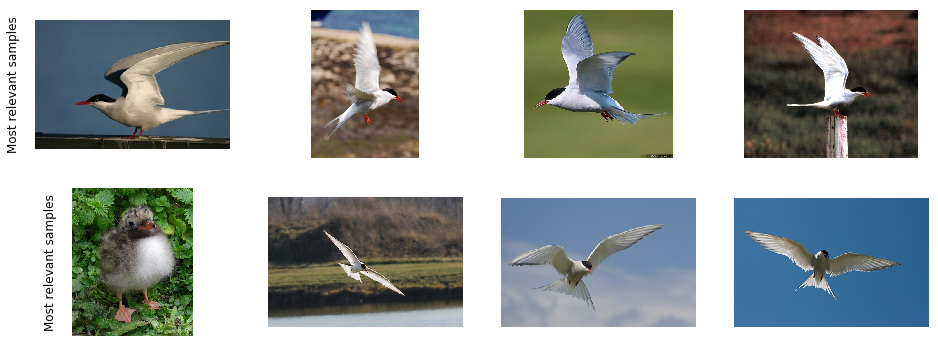

In [295]:
example_classes = [1, 5, 83, 130, 140]
for c in example_classes:
    plot_most_and_least_relevant_samples(c)

Comment: if most images are relevant, some relevant images may be included in "least relevant".  
We consider that having a relevant image considered as irrelevant is not as detrimental as having an irrelevant image considered as relevant.

However, outliers do seem to have a small relevance weights. Other images considered as irrelevant include images of low quality (low resolution, over-saturated...), with atypical background or taken from unusual angles, e.g. focused only on a specific part of the bird.

Again, ... We refer the reader to Section 6 of the main paper for a discussion on this topic.

# Loss

In [27]:
def flexible_triplet_loss(X_theta, S_psi, Y, V, D_tilde):
    """
        X_theta: N x H matrix (torch.FloatTensor)
          -> projected visual features
        S_psi: C x H matrix (torch.FloatTensor)
          -> projected semantic features
        Y: N x C binary matrix (torch.LongTensor)
          -> labels
        V: N-dimensional vector (torch.FloatTensor)
          -> relevance weights
        Dtilde: C x C (torch.FloatTensor)
          -> semantic distance between each class
          
        returns the corresponding triplet loss
        (Equation 13, without regularization omega)
    """
    N, H = X_theta.size()
    C, _ = S_psi.size()
    if DEVICE == "cpu":
        Y = Y.type(torch.FloatTensor)
    else:
        Y = Y.type(torch.cuda.FloatTensor)
    
    pairwise_compatibilities = X_theta.mm(S_psi.t()) # all the f(x_n, s_c) (Equation 3)
    prototype_compatibilities = (Y * pairwise_compatibilities).sum(dim=1).view(-1, 1).expand(-1, C) # all the f(x_n, s_y) (Equation 3)
    margin = D_tilde.unsqueeze(0).expand(N, -1, -1) * Y.unsqueeze(2).expand(-1, -1, C) 
    margin = margin.sum(dim=1) # flexible semantic margin
    
    triplet_losses = F.relu(margin + pairwise_compatibilities - prototype_compatibilities) # (Equation 12)
    triplet_losses = (1. - Y) * triplet_losses # keeping only c != yn (in Equation 13)
    triplet_losses = V.view(-1, 1) * triplet_losses # weighting by relevance
    loss = triplet_losses.sum() / (N * C)
    return loss

# Model

In [28]:
from torch.utils.data import TensorDataset

cf. Section 3.5

In [29]:
class Projection(nn.Module):
    """
        Represents a linear projection from one space (visual or semantic) to another (semantic or common space)
        Projections are partially normalized (cf. Section 3.3)
    """
    
    def __init__(self, d_input, d_embedding, gamma=1.0):
        super(Projection, self).__init__()
        self.gamma = gamma
        self.fc1 = nn.Linear(d_input, d_embedding, bias=True)
        
    def norm(self):
        """
            returns average norm of parameters
        """
        norms = (
            self.fc1.weight.norm(p=1) + self.fc1.bias.norm(p=1)
        )
        size = (
            self.fc1.weight.shape[0] * self.fc1.weight.shape[1] + self.fc1.bias.shape[0]
        )
        return norms / size

    def forward(self, x):
        x = self.fc1(x)
        x = partial_normalization(x, self.gamma)
        return x

In [36]:
class FlexibleTripletLoss:
    """
        Represents the final model
    """
    
    def __init__(self, params=None):
        # Default parameters
        self.params = {
            # Hyperparameters
            "lambda": 0., # regularization, Equation 13
            "mu_dtilde": 1.0, # mean of flexible margin, Equation 6
            "sigma_dtilde": 0.5, # standard deviation of flexible margin, Equation 6
            "gamma": 1.0, # partial normalization, Equation 8
            "setting": "thetapsi", # mapping of visual features (and semantic prototypes), Section 3.5
            
            # Other options (not hyperparameters)
            "epochs": 50,
            "learning_rate": 1e-3,
            "batch_size": 1000,
            "optimizer": optim.Adam,
            "num_workers": 4,
            "seed": 42L,
            "loss_multiplier": 1e3,
            "verbose": False,
            
            # Ablation study
            "mahalanobis_distance": True,
            "relevance_weighting": True
            # to disable partial normalization, set gamma to 0
            # to disable flexible semantic margin, set sigma_dtilde to 0 (and possible mu_dtilde to 1)
        }
        
        # Overriding default parameters if specified
        if params is not None:
            for param in params:
                self.params[param] = params[param]
            
    def fit(self, X, Y, S):
        """
            X: N x D matrix (numpy array)
              -> visual training features
            Y: N-dimensional vector (numpy array)
              -> labels
            S: C x K matrix (numpy array)
              -> training prototypes
        """        
        torch.manual_seed(self.params["seed"])
        np.random.seed(self.params["seed"])
        
        # Relevance weighting, Section 3.4
        if self.params["relevance_weighting"]: 
            V = torch.FloatTensor(relevance_weigths(X, Y))
        else:
            V = torch.ones(X.shape[0])
        
        N, D = X.shape
        C, K = S.shape
        H = K # embedding dimension is the dimension of the semantic space, Section 3.5
        
        X = torch.FloatTensor(X)
        Y_ = np.zeros([N, C])
        for n, c in enumerate(Y):
            Y_[n, c] = 1
        Y = torch.LongTensor(Y_)
        self.S = Variable(torch.FloatTensor(S).to(DEVICE))
        
        # Flexible semantic margin, Section 3.3
        self.D_tilde = Variable(distance_matrix(
            S,
            mahalanobis=self.params["mahalanobis_distance"],
            mean=self.params["mu_dtilde"], std=self.params["mu_dtilde"]*self.params["sigma_dtilde"]
        ).to(DEVICE))
        
        torch_dataset = torch.utils.data.TensorDataset(X, Y, V)
        self.loader = torch.utils.data.DataLoader(
            torch_dataset,
            batch_size=self.params["batch_size"], shuffle=True, num_workers=self.params["num_workers"]
        )
        
        # Setting (theta or theta + psi, Section 3.5)
        self.visual_projection = Projection(D, H, gamma=self.params["gamma"]).to(DEVICE)
        self.semantic_projection = Projection(K, H, gamma=1.0).to(DEVICE) # we always normalize projection of S
        
        if self.params["setting"] == "thetapsi": # theta + psi
            self.optimizer = self.params["optimizer"](
                params=list(self.visual_projection.parameters()) + list(self.semantic_projection.parameters()),
                lr=self.params["learning_rate"], weight_decay=0.
            )
        else: # only theta
            self.optimizer = self.params["optimizer"](
                params=list(self.visual_projection.parameters()),
                lr=self.params["learning_rate"], weight_decay=0.
            )
        
        self.__train()
        
    def __train(self):
        """
            trains the model for the specified number of epochs with the specified hyperparameters (and options)
        """
        for epoch in range(self.params["epochs"]):
            if self.params["verbose"]:
                print "EPOCH %i" % epoch
            for i, (inputs, labels, weights) in enumerate(self.loader):
                
                N, D = inputs.shape
                _, C = labels.shape
                
                X = Variable(inputs.to(DEVICE))
                Y = Variable(labels.to(DEVICE))
                V = Variable(weights.to(DEVICE))

                self.optimizer.zero_grad()
                
                X_theta = self.visual_projection(X)
                regularization_loss = self.visual_projection.norm()
                
                if self.params["setting"] == "thetapsi":
                    S_psi = self.semantic_projection(self.S)
                    regularization_loss = regularization_loss + self.semantic_projection.norm()
                else:
                    S_psi = self.S
                
                loss = (
                    self.params["loss_multiplier"] * flexible_triplet_loss(X_theta, S_psi, Y, V, self.D_tilde)
                    + self.params["lambda"] * regularization_loss
                ) # Equation 13
                loss.backward()
                self.optimizer.step()
            
                if self.params["verbose"]:
                    print "Loss: %.2f" % loss.item()
    
    def predict(self, X, S):
        """
            X: N x D matrix (numpy array)
              -> visual test features
            S: C x K matrix (numpy array)
              -> test prototypes
              
            Note: N (number of features) and C (number of classes) are typically not the same as in fit
        """
        X = Variable(torch.FloatTensor(X).to(DEVICE))
        S = Variable(torch.FloatTensor(S).to(DEVICE))
        
        X_theta = self.visual_projection(X)
        if self.params["setting"] == "thetapsi":
            S_psi = self.semantic_projection(S)
        else:
            S_psi = S
        
        probabilities = X_theta.mm(S_psi.t())
        return probabilities.data.cpu().numpy()

# Tests

In [33]:
def accuracy_xian(similarities_unseen, similarities_seen, dataset_split):
    selected_classes = dataset_split.unseen_classes
    predicted_classes_among_selected_classes = np.array(
        [selected_classes[c] for c in np.argmax(similarities_unseen[:,selected_classes], axis=1)]
    )
    accuracies = []
    for c in dataset_split.unseen_classes:
        idx = dataset_split.Y_te_U == c
        if idx.sum() != 0:
            accuracies.append((predicted_classes_among_selected_classes[idx] == c).sum() / float(idx.sum()))
    return np.array(accuracies).mean()

In [34]:
def run(model, dataset_split, metric, n_run=10):
    """
    Runs a model n_run times with different seeds, given an instance of a model, a dataset_split, and a metric
    (cf. method test_parameters for more information on dataset_split and metric)
    """
    seeds = range(n_run)
    scores = []
    for seed in seeds:
        model.params["seed"] = seed
        model.fit(dataset_split.X_tr, dataset_split.Y_tr_, dataset_split.S_tr)
        similarities_unseen = model.predict(dataset_split.X_te_U, dataset_split.S)
        similarities_seen = model.predict(dataset_split.X_te_S, dataset_split.S)
        score = metric(similarities_unseen, similarities_seen, dataset_split)
        scores.append(score)
        print score
    return np.array(scores)

In [ ]:
%%time
model = FlexibleTripletLoss({
    "lambda": 100, "mu_dtilde": .5, "gamma": .9, "sigma_dtilde": 0.2, "epochs": 50,
    "verbose": False
})
res = run(model, test_split_zsl, accuracy_xian, n_run=10)
res

0.6327741227814527
0.6210833329920082
0.63169902885142
0.6350047118612561
0.6257433768496536


In [1]:
res.mean()

NameError: name 'res' is not defined